# Credit Card Fraud Detection with Machine Learning Models
## Model Training
### Ian Heung

In the previous notebook, we made 5 different training datasets that feature various sampling methods to mitigate the effects of the class imbalance in the original dataset. We will now train the training data on various models and evaluate which sampling method will create a model that yields the best results on our testing data.

## Model Choices

We will choose 4 model types: 

- Decision Trees
- KNNs (K-Nearest Neighbors)
- Logistic Regression
- Support Vector Machines

Below are some of the Pros and Cons for each model type:

| Model | Pros | Cons |
|-|-|-|
| **Decision Trees** | - Handles non-linearity <br> - Provides insight into feature importance | - Prone to overfitting <br> - Bias towards features with more levels <br> - Instability with small changes in data |
| **K-Nearest Neighbors (KNN)** | - Simple methodology <br>  - Flexible with distance metrics | - Computationally intensive <br> - Sensitive to noise <br> - Not as good with higher dimensionalities|
| **Logistic Regression** | - Ideal for binary classification <br>  - Regularization available | - Assumes linear decision boundary <br> - Not ideal for large feature sets |
| **Support Vector Machines (SVM)** | - Effective in high-dimensional spaces <br> - Versatile kernels for non-linearity <br> - Robust to overfitting | - Computationally expensive <br> - Hyperparameter selection and tuning can be challenging|

In addition to each of the model types, a grid search for hyperparamter tuning will be performed each fitting where possible. Since we are testing all the differently sampled datasets on each model type, we need to be aware of the dataset size, since there are some models that will be less effective due to computational costs.

## Model Training

In [4]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve, confusion_matrix 

import warnings
warnings.filterwarnings("ignore")

### False Positives vs False Negatives

If we think back to the problem we are trying to solve, we need to focus on the precision of our model at identifying fraudulent transactions. We want to minimize the amount of actual fraudulent transactions that do not get classified correctly, even at the cost of misclassifying non-fraudulent transactions as fraudulent. This means we want to prioritize minimizing **false negatives**. Below is a confusion matrix that is an example case that shows a sample model that predicts whether transactions are fraudulent. 

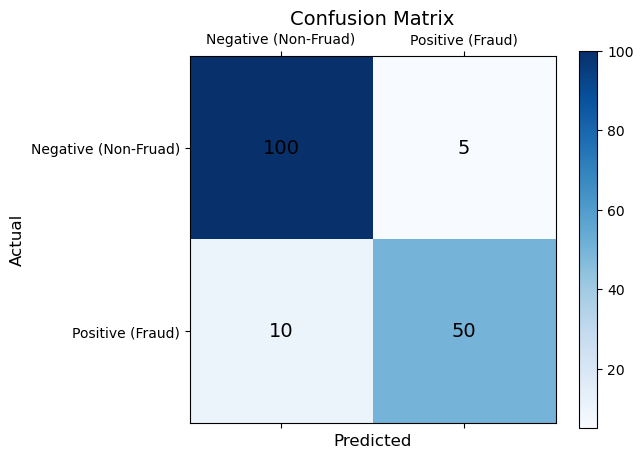

In [202]:
example_matrix = np.array([[100, 5],  # True Positives, False Negative
                             [10, 50]])  # False Positive, True Negative

fig, ax = plt.subplots()

cax = ax.matshow(example_matrix, cmap='Blues')

plt.colorbar(cax)

for (i, j), value in np.ndenumerate(example_matrix):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Negative (Non-Fruad)', 'Positive (Fraud)'])
ax.set_yticklabels(['Negative (Non-Fruad)', 'Positive (Fraud)'])

plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()

plt.show()


The model is good at detecting true positives (fraudulent cases). It might seem counterintuitive that fraudulent cases are considered positive, but because this is the class we particularly care about, it is labeled as the positive class. However, we see that there are 10 fraud cases incorrectly classified as non-fraud, these are the **false negatives**. This is concerning because it means the model failed to detect these fraudulent cases. Additionally, we observe that the model has classified 5 non-fraud cases as fraud, these are the **false positives**. This outcome is preferable, as we would rather be more cautious and flag potential fraud cases, even if there is no actual fraud. In this situation, we prefer to have more false positives, non-fraud cases classified as fraud, while minimizing false negatives, where fraud cases are classified as non-fraud.

### Load Data

Lets load in our training data for all 5 sampling cases. If we recall, these were the sampling cases each number corresponded to:

1. No Balancing at All
2. Undersampling
3. Oversampling
4. Mixed Sampling (Undersampling + Oversampling)
5. Mixed Sampling + Outlier Removal

Since we have 5 sets of data of different sizes for sampling case 4 and 5, we will store each dataset in a list corresponding to the sampling method. We will use a for loop to iterate through the list during model training.

In [217]:
# data directory
directory = 'data'

# 1 - unsampled data
xtrain_1 = pd.read_csv(os.path.join(directory, 'xtrain.csv'))
ytrain_1 = pd.read_csv(os.path.join(directory, 'ytrain.csv'))

# convert to numpy arrays
xtrain_1 = xtrain_1.values
ytrain_1 = ytrain_1.values

# 2 - undersampled data
xtrain_2 = pd.read_csv(os.path.join(directory, 'xtrain_undersampled.csv'))
ytrain_2 = pd.read_csv(os.path.join(directory, 'ytrain_undersampled.csv'))

xtrain_2 = xtrain_2.values
ytrain_2 = ytrain_2.values

# 3 - oversampled data
xtrain_3 = pd.read_csv(os.path.join(directory, 'xtrain_oversampled.csv'))
ytrain_3 = pd.read_csv(os.path.join(directory, 'ytrain_oversampled.csv'))

xtrain_3 = xtrain_3.values
ytrain_3 = ytrain_3.values

# 4 - mix sampled data
mix_sample_sizes = np.load(os.path.join(directory, 'mix_sample_sizes.npy')) # for parsing filenames of case 4 and 5
xtrain_4 = []
ytrain_4 = []

# iterate mix_sample_sizes that were saved 
for n in mix_sample_sizes:
    x = pd.read_csv(os.path.join(directory, f'xtrain_mix_{n}.csv'))
    y = pd.read_csv(os.path.join(directory, f'ytrain_mix_{n}.csv'))
    
    x = x.values
    y = y.values
    
    xtrain_4.append(x)
    ytrain_4.append(y)

# 5 - filtered mix sampled data
xtrain_5 = []
ytrain_5 = []

for n in mix_sample_sizes:
    x = pd.read_csv(os.path.join(directory, f'xtrain_mix_{n}.csv'))
    y = pd.read_csv(os.path.join(directory, f'ytrain_mix_{n}.csv'))
    
    x = x.values
    y = y.values
    
    xtrain_5.append(x)
    ytrain_5.append(y)
    
# test data
xtest = pd.read_csv(os.path.join(directory, 'xtest.csv'))
ytest = pd.read_csv(os.path.join(directory, 'ytest.csv'))

xtest = xtest.values
ytest = ytest.values

We will define our model training pipeline here. The range of the grid search terms have been determined through multiple training tests. 

When running computationally intensive models like KNN and SVM, it would take hours for the model to train, and would sometimes cause my local device to crash. So the model training pipeline is configured in a way where it will not train the data on KNN and SVM models if the input data size exceeds 50,000 datapoints. The grid search is also not as comprehensive as it can be, but I have selected a sensible range of hyperparameters to tune.

For the scoring metric, our main goal is to maximize precision for the positive class (fraududlent transactions) while also ensuring the model does not default to predicting only the positive class for transactions. To achieve this, I created a custom metric that combines the precision for the positive class with the macro F1 score. This composite score helps ensure that we don’t overfit purely on precision while also maintaining a balanced model across both classes.

In [119]:
# custom scoring function
def composite_scorer(y_true, y_pred):
    prec_pos_class = precision_score(y_true, y_pred, pos_label=1) # positive class precision
    f1_macro = f1_score(y_true, y_pred, average='macro') # macro f1 score
    
    # combine the two scores and divide by 2
    comp_score = (prec_pos_class + f1_macro) / 2

    return comp_score

In [203]:
# model training pipeline
def train_models(xtrain, ytrain):
    
    # intialize our model types
    decision_trees = DecisionTreeClassifier()
    knn = KNeighborsClassifier()
    logistic = LogisticRegression()
    svm = SVC()

    # decision trees grid search hyperparameters
    dt_hyperparams = {
            "max_depth": [10, 20, 30],
            "criterion": ["gini", "entropy"],
            "max_leaf_nodes": [10, 20, 30]
        }

    # knn  trees grid search hyperparameters
    knn_hyperparams = {
        'n_neighbors': [2, 5, 10, 15],
        'weights': ['uniform', 'distance']
        }

    # logistic regression hyperparameters
    logistic_hyperparams = {
        "penalty": ['l1', 'l2'], 
        'C': [0.01, 0.1, 1, 10]
        }

    # support vector machines hyperparameters
    svm_hyperparams = {
        'C': [0.1, 1, 10], 
        'kernel': ['rbf', 'poly', 'linear']
        }

    # custom scorer
    composite_score = make_scorer(composite_scorer)
    
    # put into a triplet for parsing into for loop
    models = [('Decision Trees', decision_trees, dt_hyperparams), 
            ('KNN', knn, knn_hyperparams), 
            ('Logistic Regression', logistic, logistic_hyperparams),
            ('Support Vector Machines', svm, svm_hyperparams)]
    
    # save results to a dictionary
    results = {}
    
    # iterate list of triplets
    for name, model, grid in models:
        
        if len(xtrain) >= 50000:
            cv_folds = 3
        else:
            cv_folds = 5
            
        # skip training for KNN and SVM on very large datasets
        if (len(xtrain)) < 50000 or (name != 'KNN' and name != 'Support Vector Machines'):
            clf = GridSearchCV(
                estimator=model, 
                param_grid=grid,
                scoring=composite_score, 
                cv=cv_folds,  
                verbose=3, 
                n_jobs=-1
            )

            print("Training", name, "Model")
            
            # fit training data                    
            classifier = clf.fit(xtrain, ytrain)
            
            print("Validation fitting with best custom score:", clf.best_score_)
            print("Best parameters found from grid search: ", clf.best_params_)
            print()

            results[name] = [classifier.best_estimator_, clf.best_score_, clf.best_params_]
        else:
            results[name] = 'Skipped'
            print(name, 'Model skipped due to long training time')
            print()
            
    return results

#### 1 - No Sampling

The dataset is too large, so we don't train KNN and SVM models.

In [124]:
results_1 = train_models(xtrain_1, ytrain_1)

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best F1 score: 0.9075291126855557
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 30, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time
Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with best F1 score: 0.8766773515631795
Best parameters found from grid search:  {'C': 10, 'penalty': 'l2'}

Support Vector Machines Model skipped due to long training time


#### 2 - Undersampling

In [204]:
results_2 = train_models(xtrain_2, ytrain_2)

Training Decision Trees Model
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Validation fitting with best custom score: 0.9296490124441315
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': 10}

Training KNN Model
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Validation fitting with best custom score: 0.9543922609447566
Best parameters found from grid search:  {'n_neighbors': 10, 'weights': 'uniform'}

Training Logistic Regression Model
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Validation fitting with best custom score: 0.9544874558551086
Best parameters found from grid search:  {'C': 0.01, 'penalty': 'l2'}

Training Support Vector Machines Model
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Validation fitting with best custom score: 0.9565152765717165
Best parameters found from grid search:  {'C': 10, 'kernel': 'rbf'}



#### 3 - Oversampling

The dataset is too large, so we don't train KNN and SVM models.

In [126]:
results_3 = train_models(xtrain_3, ytrain_3)

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best F1 score: 0.9684235166896888
Best parameters found from grid search:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time
Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with best F1 score: 0.9590379159945188
Best parameters found from grid search:  {'C': 0.01, 'penalty': 'l2'}

Support Vector Machines Model skipped due to long training time


#### 4 - Mixed Sampling

The dataset size vaires. It is too large for the first two mixed sampling sets, so we don't train KNN and SVM models on them. We do train KNN and SVM models on the remaining 3.

In [127]:
# 0 - 227450
results_4_0 = train_models(xtrain_4[0], ytrain_4[0]) # No KNN, SVM
# 1 - 71926
results_4_1 = train_models(xtrain_4[1], ytrain_4[1]) # No KNN, SVM
# 2 - 22744
results_4_2 = train_models(xtrain_4[2], ytrain_4[2])
# 3 - 7192
results_4_3 = train_models(xtrain_4[3], ytrain_4[3])
# 4 - 2274
results_4_4 = train_models(xtrain_4[4], ytrain_4[4])

results_4 = [results_4_0, results_4_1, results_4_2, results_4_3, results_4_4]

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best F1 score: 0.9689208828903576
Best parameters found from grid search:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time
Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with best F1 score: 0.9590119878436459
Best parameters found from grid search:  {'C': 0.1, 'penalty': 'l2'}

Support Vector Machines Model skipped due to long training time
Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best F1 score: 0.9691873818830502
Best parameters found from grid search:  {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time
Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with be

#### 5 - Mixed Sampling + Outlier Removal

Same as 4 - Mixed Sampling, the dataset size vaires. The same training methods are applied.

In [128]:
# 0 - 227450
results_5_0 = train_models(xtrain_5[0], ytrain_5[0]) # No KNN, SVM
# 1 - 71926
results_5_1 = train_models(xtrain_5[1], ytrain_5[1]) # No KNN, SVM
# 2 - 22744
results_5_2 = train_models(xtrain_5[2], ytrain_5[2])
# 3 - 7192
results_5_3 = train_models(xtrain_5[3], ytrain_5[3])
# 4 - 2274
results_5_4 = train_models(xtrain_5[4], ytrain_5[4])

results_5 = [results_5_0, results_5_1, results_5_2, results_5_3, results_5_4]

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best F1 score: 0.9689208828903576
Best parameters found from grid search:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time
Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with best F1 score: 0.9590119878436459
Best parameters found from grid search:  {'C': 0.1, 'penalty': 'l2'}

Support Vector Machines Model skipped due to long training time
Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best F1 score: 0.9691663995160233
Best parameters found from grid search:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time
Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with be

The models are now all trained. Lets see the initial training results of all the sampling and model types by looking at the performance on validation data, and the hyperparemeters selected from the grid search.

In [44]:
# we define a function for easy viewing of our validation results
def print_results(results):
    # reference each model the dictonary keys 
    for k in results.keys():
        # If a model is skipped, this is the print output
        if results[k] == 'Skipped':
            print("Model: ", k)
            print(results[k])
            print()
        else:
            print("Model: ", k)
            print("Best Score: ", results[k][1])
            print("Best Parameters: ", results[k][2])
            print()

#### 1 - No Sampling

In [46]:
print_results(results_1)

Model:  Decision Trees
Best Score:  0.8278607748819664
Best Parameters:  {'criterion': 'gini', 'max_depth': 30, 'max_leaf_nodes': 20}

Model:  KNN
Skipped due to long training time

Model:  Logistic Regression
Best Score:  0.7422702025241684
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped due to long training time



#### 2 - Undersampling

In [114]:
print_results(results_2)

Model:  Decision Trees
Best Score:  0.9433884328991853
Best Parameters:  {'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': 10}

Model:  KNN
Best Score:  0.981669776119403
Best Parameters:  {'n_neighbors': 10, 'weights': 'uniform'}

Model:  Logistic Regression
Best Score:  0.9765948632974316
Best Parameters:  {'C': 0.01, 'penalty': 'l2'}

Model:  Support Vector Machines
Best Score:  0.9953488372093023
Best Parameters:  {'C': 0.1, 'kernel': 'poly'}



#### 3 - Oversampling

In [48]:
print_results(results_3)

Model:  Decision Trees
Best Score:  0.9656717922424497
Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Skipped due to long training time

Model:  Logistic Regression
Best Score:  0.9437339776289977
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped due to long training time



#### 4 - Mixed Sampling
There is a scrollable output since the output gets truncated.

In [54]:
# for loop to iterate through the different mixed sampling models
for i in range(len(results_4)):
    print("Number of Datapoints", mix_sample_sizes[i])
    print_results(results_4[i])
    print()

Number of Datapoints 227450
Model:  Decision Trees
Best Score:  0.9657180704328532
Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Skipped due to long training time

Model:  Logistic Regression
Best Score:  0.9439042402778822
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped due to long training time


Number of Datapoints 71926
Model:  Decision Trees
Best Score:  0.9659509137683074
Best Parameters:  {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 30}

Model:  KNN
Skipped due to long training time

Model:  Logistic Regression
Best Score:  0.9433534908654139
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped due to long training time


Number of Datapoints 22744
Model:  Decision Trees
Best Score:  0.9650032304478021
Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Best Score:  0.9946642375317349
Best Parameters:  {'n_neigh

#### 5 - Mixed Sampling + Outlier Removal
There is a scrollable output since the output gets truncated.

In [55]:
# for loop to iterate through the different mixed sampling models
for i in range(len(results_5)):
    print("Number of Datapoints", mix_sample_sizes[i])
    print_results(results_5[i])
    print()

Number of Datapoints 227450
Model:  Decision Trees
Best Score:  0.9657180704328532
Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Skipped due to long training time

Model:  Logistic Regression
Best Score:  0.9439042402778822
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped due to long training time


Number of Datapoints 71926
Model:  Decision Trees
Best Score:  0.9659645506128655
Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Skipped due to long training time

Model:  Logistic Regression
Best Score:  0.9433534908654139
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped due to long training time


Number of Datapoints 22744
Model:  Decision Trees
Best Score:  0.9650032304478021
Best Parameters:  {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 30}

Model:  KNN
Best Score:  0.9946642375317349
Best Parameters:  {'n_neigh

From our intial preview of the models, even the base case no sampling models performed decently despite the data imbalance, with 70-80% on our custom weighted score. But we also see some models that have scores that seem too high, close to 99-100%, which is an indication of overfitting. Most of the results hover around 93-96%. Because of the size of some datasets, we were not able to train KNN and SVM models on those datasets. This was one of the tradeoffs we had to make when using these two models due to their high computational costs.

### Model Evaluation

Now that we have trained our models, it is time to evaluate them on our testing data. We will evaluate all the models and generate predictions on the test data. We create a function to parse in our model training results and filter out the models that were skipped due to computational limitations. 

In [122]:
# function to evaluate and make predictions on test data
def evaluate_results(results, xtest):
    ypred_array = []
    for k in results.keys():
        if results[k] == 'Skipped':
            ypred_array.append([])
        else:
            model = results[k][0]
            ypred = model.predict(xtest)
            ypred_array.append(ypred)
    return ypred_array

In [146]:
ypreds_1 = evaluate_results(results_1, xtest)
ypreds_2 = evaluate_results(results_2, xtest)
ypreds_3 = evaluate_results(results_3, xtest)

# append the predictions for each mixed sampled dataset into a list
ypreds_4 = []
for i in range(len(results_4)):
     ypreds_4.append(evaluate_results(results_4[i], xtest))
     
ypreds_5 = []
for i in range(len(results_5)):
     ypreds_5.append(evaluate_results(results_5[i], xtest))


The easiest way to visualize how our model is doing is to use a confusion matrix. Because we skipped training KNN and SVM models for large datasets, we need to add an option to display 2 models instead of 4 for each sampling set. The following custom function will produce a confusion matrix plot and save it to a plots folder.

In [234]:
def plot_confusion_matrix(ypreds, title, filename, num_plots, show_plot):
    if num_plots == 2:
        ypreds = ypreds[0:3:2]
        model_types = ["Decision Trees", "Logistic Regression"]
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 2x1 grid of subplots

        # iterate each subplot
        for m, ax in enumerate(axes.ravel()):
            cm = confusion_matrix(ytest, ypreds[m])
            cax = ax.matshow(cm, cmap='Blues')

            # annotate each cell with the number of instances
            for (i, j), value in np.ndenumerate(cm):
                ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

            ax.set_xlabel('Predicted', fontsize=12)
            ax.set_ylabel('Actual', fontsize=12)

            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels(['Non-Fraud', 'Fraud'])
            ax.set_yticklabels(['Non-Fraud', 'Fraud'])

            ax.set_title(f'{model_types[m]} Confusion Matrix')

    elif num_plots == 4:        
        model_types = ["Decision Trees", "KNN", "Logistic Regression", "SVM"]
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid of subplots

        for m, ax in enumerate(axes.ravel()):
            cm = confusion_matrix(ytest, ypreds[m])
            cax = ax.matshow(cm, cmap='Reds')

            # Annotate each cell with the number of instances
            for (i, j), value in np.ndenumerate(cm):
                ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

            ax.set_xlabel('Predicted', fontsize=12)
            ax.set_ylabel('Actual', fontsize=12)

            ax.set_xticklabels(['Non-Fraud', 'Fraud'])
            ax.set_yticklabels(['Non-Fraud', 'Fraud'])

            ax.set_title(f'{model_types[m]} Confusion Matrix')
            
    else:
        print("Invalid number of plots")
        return
        
    fig.suptitle(title, fontsize = 16)
    plt.tight_layout()
    
    # save plot
    directory = 'plots'
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    plt.savefig(os.path.join(directory, f'{filename}.png'))
    
    # option to show plot in output
    if show_plot:
        plt.show()
    else:
        plt.close(fig)

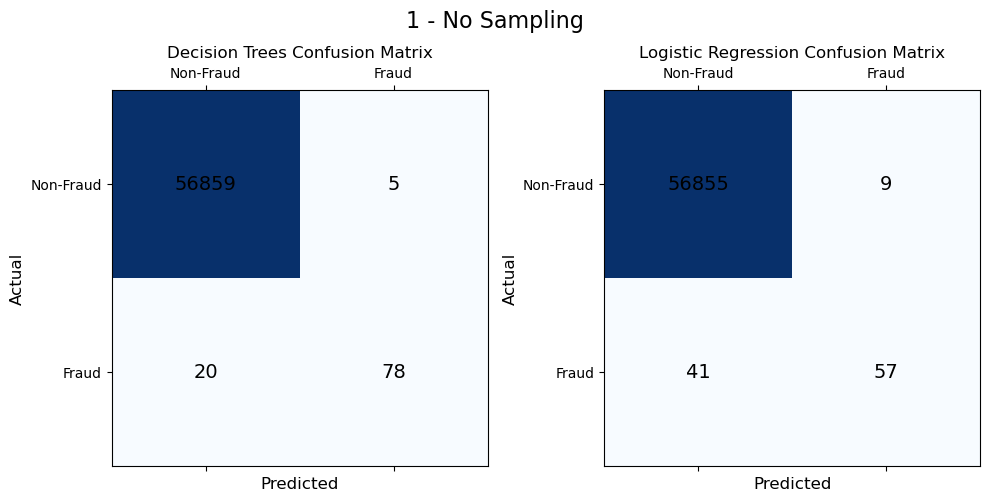

In [235]:
plot_confusion_matrix(ypreds_1, '1 - No Sampling' , '1_no_sampling', 2, show_plot=True)

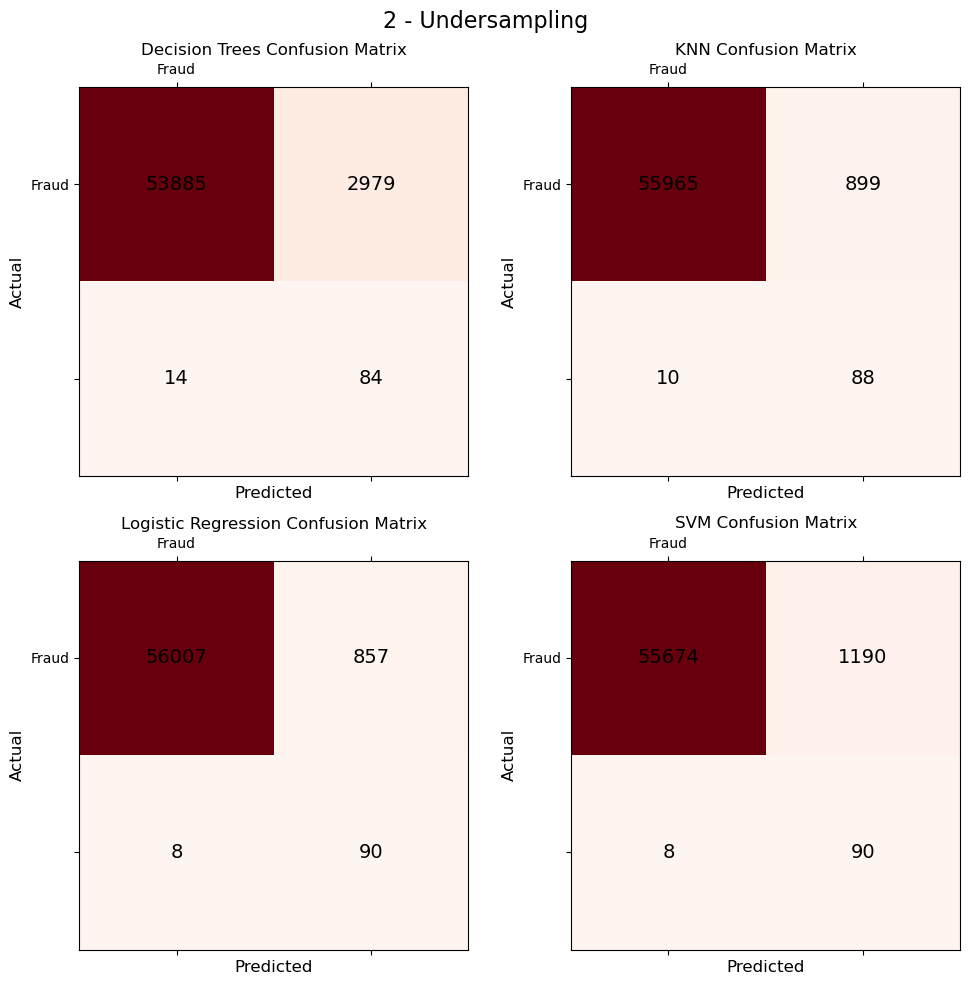

In [236]:
plot_confusion_matrix(ypreds_2, '2 - Undersampling', '2_undersampling', 4,  show_plot=True)

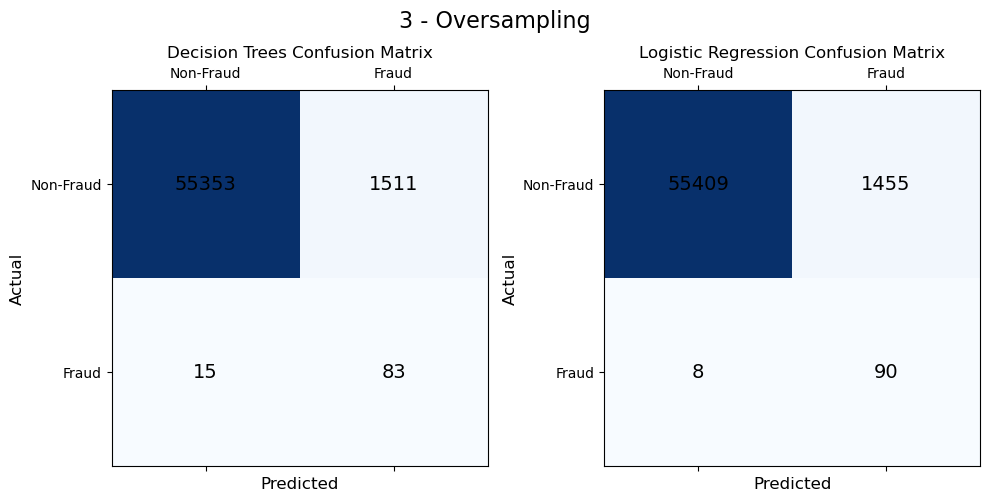

In [237]:
plot_confusion_matrix(ypreds_3, '3 - Oversampling', '3_oversampling', 2, show_plot=True)

In [238]:
# iterate through ypreds_4 and assign filename based on num data points
for i in range(len(ypreds_4)): 
    # our num_plots changes if the sampling set did not train KNN and SVM models
    if len(ytrain_4[i]) >= 50000:
        num_plots = 2
    else:
        num_plots = 4
    
    # do not show plots as will fill up whole screen
    plot_confusion_matrix(ypreds_4[i], f'4 - Mixed Sampling ({mix_sample_sizes[i]} Training Points)', f'4_mix_sampling_{mix_sample_sizes[i]}', num_plots, show_plot=False) 

In [239]:
# iterate through ypreds_5 and assign filename based on num data points
for i in range(len(ypreds_5)): 
    # our num_plots changes if the sampling set did not train KNN and SVM models
    if len(ytrain_5[i]) >= 50000:
        num_plots = 2
    else:
        num_plots = 4
    
    # do not show plots as will fill up whole screen
    plot_confusion_matrix(ypreds_5[i], f'5 - Mixed Sampling + Outliers Removed ({mix_sample_sizes[i]} Training Points)', f'5_filtered_sampling_{mix_sample_sizes[i]}', num_plots, show_plot=False) 

NameError: name 'ypred_dt_outliers' is not defined

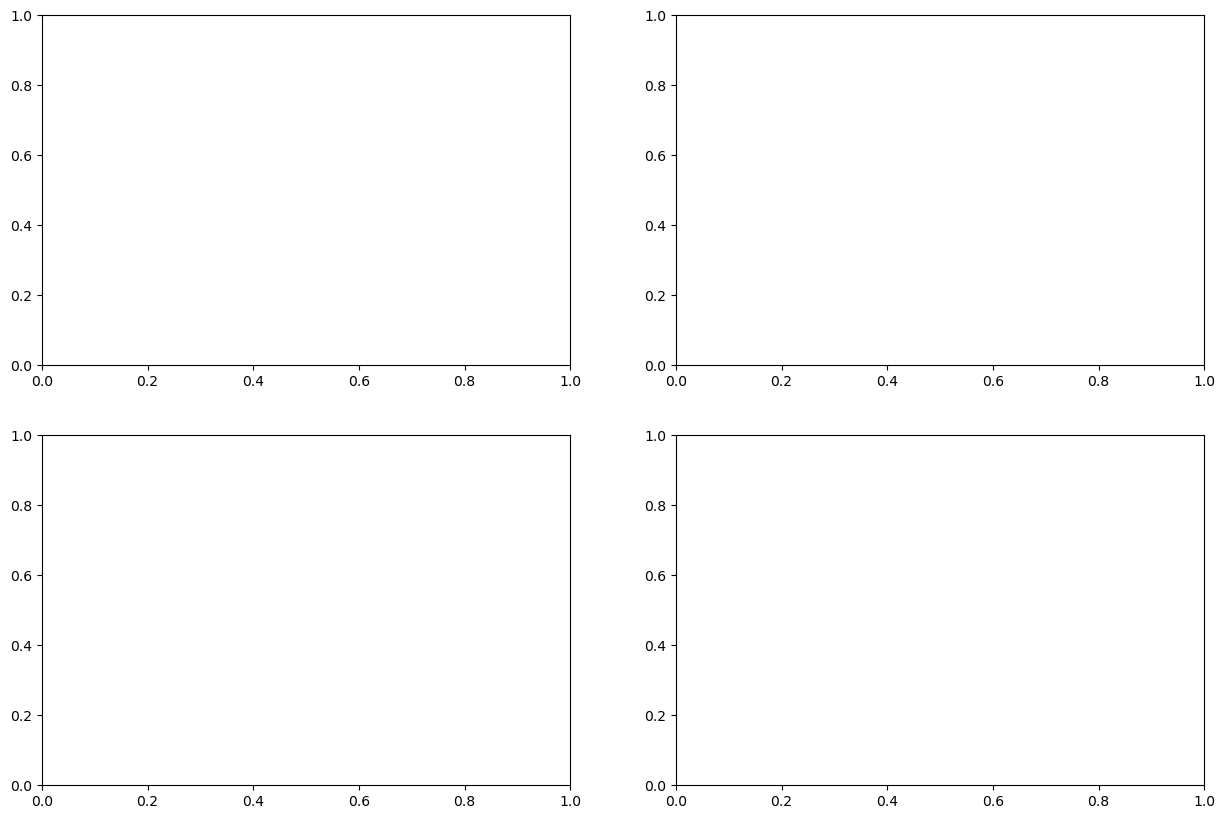

In [178]:
# ROC plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

fpr_outlier_1, tpr_outlier_1, _ = roc_curve(ytest, ypred_dt_outliers)
fpr_filtered_1, tpr_filtered_1, _ = roc_curve(ytest, ypred_dt_filtered) 

ax1 = axes[0][0]
ax1.plot(fpr_outlier_1, tpr_outlier_1, label='With Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_dt_outliers)))
ax1.plot(fpr_filtered_1, tpr_filtered_1, label='Without Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_dt_filtered)))
ax1.set_title('ROC Curve: Decision Trees')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right', fontsize=10)

fpr_outlier_2, tpr_outlier_2, _ = roc_curve(ytest, ypred_knn_outliers)
fpr_filtered_2, tpr_filtered_2, _ = roc_curve(ytest, ypred_knn_filtered) 

ax2 = axes[0][1]
ax2.plot(fpr_outlier_2, tpr_outlier_2, label='With Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_knn_outliers)))
ax2.plot(fpr_filtered_2, tpr_filtered_2, label='Without Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_knn_filtered)))
ax2.set_title('ROC Curve: KNN')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc='lower right', fontsize=10)

fpr_outlier_3, tpr_outlier_3, _ = roc_curve(ytest, ypred_logistic_outliers)
fpr_filtered_3, tpr_filtered_3, _ = roc_curve(ytest, ypred_logistic_filtered) 

ax3 = axes[1][0]
ax3.plot(fpr_outlier_3, tpr_outlier_3, label='With Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_logistic_outliers)))
ax3.plot(fpr_filtered_3, tpr_filtered_3, label='Without Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_logistic_filtered)))
ax3.set_title('ROC Curve: Logistic Regression')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(loc='lower right', fontsize=10)

fpr_outlier_4, tpr_outlier_4, _ = roc_curve(ytest, ypred_svm_outliers)
fpr_filtered_4, tpr_filtered_4, _ = roc_curve(ytest, ypred_svm_filtered) 

ax3 = axes[1][1]
ax3.plot(fpr_outlier_4, tpr_outlier_4, label='With Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_svm_outliers)))
ax3.plot(fpr_filtered_4, tpr_filtered_4, label='Without Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, ypred_svm_filtered)))
ax3.set_title('ROC Curve: SVM')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(loc='lower right', fontsize=10)

plt.show()

[array([1, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([1, 0, 0, ..., 0, 0, 0], dtype=int64)]